## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
import contextily as ctx

In [3]:
#dynamic methods, which visualize figures and gridplots better - this case has nothing to do with the preparation, but serves us for simplification. 

#Create a gridplot that automatically arranges plots from left to right and horizontally
def create_gridplot(title="Unnamed Plot",figsize=(12,8),gridsize=(6,3),plotsizes=[(3,2),(1,1),(1,2)],names=[],tight_layout=False):
    fig  = create_fig(title=title,figsize=figsize)
    fig=style_fig(fig,title=title,tight_layout=tight_layout)
    
    axes = []
    taken = np.zeros(gridsize)
    
    for plot in plotsizes:
        spot = findSpot(taken,plot)
        if spot:
            for i in range(spot[0],spot[0]+plot[0]):
                for u in range(spot[1],spot[1]+plot[1]):
                    taken[i,u] = 1
            axes.append(plt.subplot2grid(gridsize, spot, colspan=plot[1], rowspan=plot[0]))
        else: 
            print("no spot found")

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')
        
    if len(axes) == len(names):
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i=i+1
    return fig,axes



# Give Figure a styling
def style_fig(fig,title="Unnamed Plot",tight_layout=False):
    fig.suptitle(title, x=0.5, y=0.98, color='black',size=15,fontname="Arial")
    if tight_layout:
        fig.tight_layout()
    return fig

# create figure
def create_fig(title = "Unnamed Plot",figsize=(12,8)):
    fig = plt.figure(figsize = figsize)
    fig = style_fig(fig,title)
    return fig

# Create Subplot, return figure and array of axes
def create_subplot_fig(title = "Unnamed Plot",figsize=(12,8),x=1,y=1,names=[],tight_layout=False):
    
    fig,axes = plt.subplots(nrows=y,ncols=x,figsize=figsize)
    fig = style_fig(fig,title=title,tight_layout=tight_layout)

    if x*y == 1:
        axes = np.array([axes])
    
    if x>1 and y>1:
        axes = axes.flatten()

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')

    # case more than one
    if len(names) == x*y:
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i = i+1                 
    return fig,axes

#Helper function to find a spot in a matrix
def findSpot(matrix,plot):
    maxrows = matrix.shape[0] #amount of rows
    maxcols = matrix.shape[1] #amount of cols
    
    rowc = -1
    for row in matrix:
        rowc = rowc+1
        itemc = -1
        for item in row:
            itemc = itemc + 1
            if (rowc + plot[0] > maxrows) or (itemc + plot[1] > maxcols):
                continue
            if item == 0: #find potential spot
                space = True
                for i in range(rowc,rowc+plot[0]):#find out whether it fits
                    for u in range(itemc,plot[1]):
                        if matrix[i,u] == 1: 
                            space = False
                if space:
                    return((rowc,itemc))
    return False


---------------------------------------------------------------

# 1. Data Cleaning

In [4]:
# Read in dataset (can be sample of original data)
df = pd.read_parquet("../data/df_cleaned_29_08_2021.parquet")

In [5]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,12,True,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,15,True,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,8,True,March,Friday,9,2017-03-03,3,4,8,True
14574858,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,11,False,July,Sunday,30,2017-07-23,7,6,11,False
3642582,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,11,False,February,Saturday,8,2017-02-25,2,5,11,False


In [7]:
# Make Timestamps useable
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')

df.head(2)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.1,NaN,NaN,8.0,7.0,...,12,True,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,15,True,August,Thursday,33,2017-08-17,8,3,15,True


## Delete unrealistic values

In [8]:
oldsize=df.index.size

print("0$ Total Trips:",df[df["Trip Total"]==0].index.size)
print("0$ Fare Trips:",df[df["Fare"]==0].index.size)
print("0 Seconds Trips",df[df["Trip Seconds"]==0].index.size)

df = df[df['Trip Miles'].notna()]
df = df[df['Trip Total'].notna()]

#kick out values under 2$
df = df.copy()[df["Fare"]>=2]
df = df.copy()[df["Trip Seconds"]>=60]

print("Kept",np.round((df.index.size/oldsize)*100,2),"% of data")

0$ Total Trips: 0
0$ Fare Trips: 0
0 Seconds Trips 0
Kept 100.0 % of data


In [9]:
#delete Largest 0.1% of Trip Total and Trip Seconds
oldsize=df.index.size

df_filtered = df.nsmallest(int(df.index.size * 0.999), "Trip Total", keep='first')
total_filter = df_filtered["Trip Total"].max()
min_total = df_filtered["Trip Total"].min()
print("Max Total:",total_filter)
print("Min Total:",min_total)

df_filtered = df.nsmallest(int(df.index.size * 0.999), "Trip Seconds", keep='first')
seconds_filter = df_filtered["Trip Seconds"].max()
min_seconds = df_filtered["Trip Seconds"].min()
print("Max Seconds:",seconds_filter)
print("Min Seconds:",min_seconds)

df = df.copy()[(df["Trip Total"] <= total_filter)&
               (df["Trip Seconds"]<=seconds_filter)]
print("Kept",np.round(df.index.size / oldsize,4)*100,"percent of data")

Max Total: 103.0
Min Total: 2.0
Max Seconds: 5340.0
Min Seconds: 60.0
Kept 99.8 percent of data


In [10]:
#We are focusing on data from January to November 2017, as there is no weather data available after November. 
#Hence, we kick out all values of December and 2018.
oldsize =  df.index.size

df['start_month'] = df['Trip Start Timestamp'].dt.month
df['start_year'] = df['Trip Start Timestamp'].dt.year
df['end_month'] = df['Trip End Timestamp'].dt.month
df['end_year'] = df['Trip End Timestamp'].dt.year

df = df[(df['start_year'] == 2017 ) & (df['end_year'] == 2017) ]
df = df[(df['start_month'] !=12 ) & (df['end_month'] !=12) ]
print("Kept",np.round(df.index.size /oldsize,4)*100,"percent of data")

#Drop columns again
df.drop(columns=['start_month', 'start_year', 'end_month' , 'end_year'], inplace = True)

print()
#Min and Max Trip Start and end
print("New min start: ",min(df['Trip Start Timestamp']))
print("New min end: ",min(df['Trip End Timestamp']))
print("New max start: ",max(df['Trip Start Timestamp']))
print("New max end: ",max(df['Trip End Timestamp']))

Kept 100.0 percent of data

New min start:  2017-01-01 00:00:00
New min end:  2017-01-01 00:00:00
New max start:  2017-11-30 23:45:00
New max end:  2017-11-30 23:45:00


In [11]:
#check null values in payment type and company
pay_verifier = df['Payment Type'].dropna()
print("Number of null values within column payment type: ",len(df)-len(pay_verifier))

com_verifier = df['Company'].dropna()
print("Number of null values within column payment type: ",len(df)-len(com_verifier))
print()
print("if 0, we don't have to drop something.")

Number of null values within column payment type:  0
Number of null values within column payment type:  0

if 0, we don't have to drop something.


-------------------------

# 2. Geodata Preparation

In [12]:
# Read In Chicago Map Data
chicago_census_tracts = gpd.read_file("../data/chicago-census-tracts.geojson")
chicago_census_tracts["geoid10"] = chicago_census_tracts["geoid10"].astype(float)
chicago_census_tracts["centroid"] = chicago_census_tracts.geometry.centroid

chicago_com_areas = gpd.read_file("../data/chicago-community-areas.geojson")
chicago_com_areas["area_num_1"]=chicago_com_areas["area_num_1"].astype(int)
chicago_com_areas["centroid"] = chicago_com_areas["geometry"].centroid

<ipython-input-12-1225bc78b28e>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago_census_tracts["centroid"] = chicago_census_tracts.geometry.centroid
<ipython-input-12-1225bc78b28e>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago_com_areas["centroid"] = chicago_com_areas["geometry"].centroid


## Record Quality Problems
A big issue of our dataset is that geospatial data is not provided in a consistent, comparable way. More specifically, spatial Pickup and Dropoff information is provided on either Community Area or Census Tract level. This poses two problems.
1. we cannot analyse or even visualise data that is on two different levels
2. Different Community Areas are not the same size, which makes comparability between community areas difficult. The same goes for Census Tracts

Note: The Dataset also provides coordinates in form of Lat/Long values. However, these are only the centroids of the respective Community Area or Census Tract and thus do not solve our problem.

We first analyse how much of a problem this is.

In [13]:
df_accuracy = df.copy()[(~df["Pickup Community Area"].isnull()&~df["Dropoff Community Area"].isnull()) |
                       (~df["Pickup Census Tract"].isnull()&~df["Dropoff Census Tract"].isnull())]
                        # For Accuracy Analysis, only use records that have full PU and DO data on at least one level

left=np.round(len(df_accuracy.index)/len(df.index)*100,2)
print(len(df_accuracy.index),"Records from",len(df.index),"remained after geo-cleaning.","("+str(left)+"%)")
df_accuracy.head(3)

988442 Records from 1087753 remained after geo-cleaning. (90.87%)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.1,NaN,NaN,8.0,7.0,...,12,True,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,15,True,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.2,NaN,NaN,6.0,8.0,...,8,True,March,Friday,9,2017-03-03,3,4,8,True


In [14]:
import math
def get_accuracy(pu_com_area,do_com_area,pu_census_tr,do_census_tr):
    acc = np.nan
    if not math.isnan(pu_com_area) and not math.isnan(do_com_area):
        acc = "com"
    if not math.isnan(pu_census_tr) and not math.isnan(do_census_tr):
        acc="cens"
    return acc

df_accuracy["geo_accuracy"] = df_accuracy.apply(lambda x: get_accuracy(x["Pickup Community Area"],x["Dropoff Community Area"],x["Pickup Census Tract"],x["Dropoff Census Tract"]),axis=1)

if len(df_accuracy[df_accuracy["geo_accuracy"].isnull()]) > 0:
    df_accuracy[df_accuracy["geo_accuracy"].isnull()]
    print("something is wrong.")
       
    
else:
    print("everything went as planned.")
    df_accuracy.head(5)  


everything went as planned.


In [15]:
# create indicators for whether census tract and/or community area is assigned.
df_accuracy["cens_tract"]=df_accuracy["geo_accuracy"] == "cens"
df_accuracy["cens_tract"] = df_accuracy["cens_tract"].astype(int)
df_accuracy["com_area"]=df_accuracy["geo_accuracy"] == "com"
df_accuracy["com_area"] = df_accuracy["com_area"].astype(int)

# get number of Pick-ups for every community area and census tract.
df_accuracy=df_accuracy.groupby("Pickup Community Area").agg(census_tract=("cens_tract","sum"),
                                                          community_area=("com_area","sum"))


# get taxiride count for each geo spatial hierarchy for later plotting.
df_accuracy.index=df_accuracy.index.astype(int)
df_accuracy_sum = pd.DataFrame(df_accuracy.sum(),columns=["sum"])

# add geometries and area indicator.
df_accuracy = pd.merge(df_accuracy,chicago_com_areas,left_index=True,right_on="area_num_1",how="left")
df_accuracy = gpd.GeoDataFrame(df_accuracy,geometry="geometry")

# get share of rides that have census tract information of all rides that appeared within this commuity area.
df_accuracy["census_tract_percent"] = df_accuracy["census_tract"] / (df_accuracy["census_tract"]+df_accuracy["community_area"])

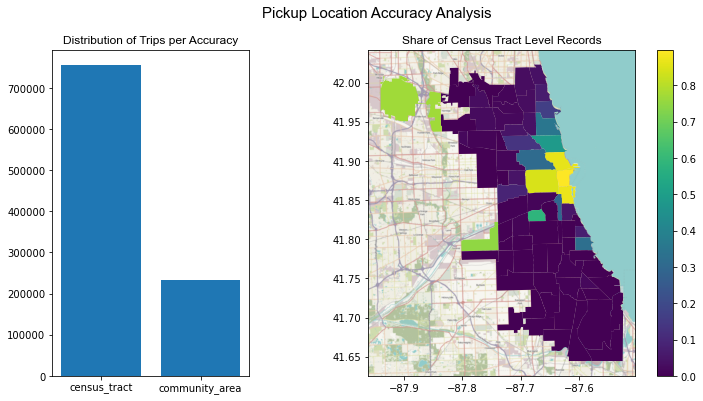

In [16]:
#Plotting the geographical accuracy of the given data.
fig,axes=create_gridplot(title = "Pickup Location Accuracy Analysis",figsize=(12,6),gridsize=(1,3),plotsizes=[(1,1),(1,2)],names=["Distribution of Trips per Accuracy","Share of Census Tract Level Records"])
plot = df_accuracy.plot(ax=axes[1],column="census_tract_percent",legend=True)
ctx.add_basemap(ax=axes[1],zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
#map scaling.
chicago_com_areas.plot(ax=axes[1],alpha=0) 

_=axes[0].bar(df_accuracy_sum.index,df_accuracy_sum["sum"])


* While many rides actually have the more detailed census tract information, 1/3 only provide the community area.
* Information in the outer city areas is less detailed.

To solve this problem, we introduce H3, which is a grid system that segments the earth into hexagons of equal size, which enables us to bring our data to one comparable level. It also gives us the ability to jitter our data in a way that very accurately approximates reality. In the following, we explain why this works.

### Calculating H3 Polygons
Our Goal is to build a H3 Grid that fills out our Community Areas and Census Tracts separately. We do this so that we can then artificially distribute our trips throughout our h3 polygons. 

The idea is that to each record, we assign a random H3 Polygon that is within the bounds of the most detailed information that we have. For example, if a record has both a Census Tract and a Community Area Value, we assign a random H3 Polygon within the respective Census Tract, as Census Tracts are more granular than Community Areas. If it has no Census Tract Data, we assign a random polygon from its Community Area.

### Building Chicago H3 grids
We first have to fill both Census Tracts and Community Areas with H3 Polygons in order to perform our randomisation later.

In [17]:
# set h3 resolution level
h3_resolution = 9

In [18]:
# Create an empty dataframe to write data into
h3_census_tracts = []

# looping through all census tract to fill them with H3's of the set resolution
for _,row in chicago_census_tracts.iterrows():
    census_tract=row["geoid10"]
    geometry=row["geometry"][0]
    
    poly_geojson = gpd.GeoSeries([geometry]).__geo_interface__
    # Parse out geometry key from GeoJSON dictionary
    poly_geojson = poly_geojson['features'][0]['geometry'] 

    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)
    

    # Fill the dictionary with H3 Hexagons
    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

    for h3_hex in h3_hexes:
        h3_geo_boundary = shapely.geometry.Polygon(
            h3.h3_to_geo_boundary(h3_hex,geo_json=True))
        h3_centroid = h3.h3_to_geo(h3_hex)
        h3_census_tracts.append({"census_tract":census_tract,
                            "h3_id":h3_hex,
                            "h3_geo_boundary":h3_geo_boundary,
                            "h3_centroid":h3_centroid})
    
h3_census_tracts = pd.DataFrame(h3_census_tracts)

In [19]:
h3_census_tracts.head(3)

,census_tract,h3_id,h3_geo_boundary,h3_centroid
0,1.703184e+10,892664cdd33ffff,POLYGON ((-87.63097420989419 41.73812710565164...,"(41.736394253643034, -87.6303911482679)"
1,1.703184e+10,892664cddafffff,POLYGON ((-87.62676567861821 41.73874988022668...,"(41.737016985340794, -87.62618276071909)"
2,1.703184e+10,892664cdda3ffff,POLYGON ((-87.62553570343381 41.74166064645635...,"(41.7399276838452, -87.62495279316144)"


In [20]:
# Create an empty dataframe to write data into
h3_com_areas = []

# looping through all community areas to fill them with H3's of the set resolution
for _,row in chicago_com_areas.iterrows():
    com_area=row["area_num_1"]
    geometry=row["geometry"][0]
    
    poly_geojson = gpd.GeoSeries([geometry]).__geo_interface__
    # Parse out geometry key from GeoJSON dictionary
    poly_geojson = poly_geojson['features'][0]['geometry'] 

    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)
    

    # Fill the dictionary with H3 Hexagons
    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

    for h3_hex in h3_hexes:
        h3_geo_boundary = shapely.geometry.Polygon(
            h3.h3_to_geo_boundary(h3_hex,geo_json=True))
        h3_centroid = h3.h3_to_geo(h3_hex)
        h3_com_areas.append({"com_area":com_area,
                            "h3_id":h3_hex,
                            "h3_geo_boundary":h3_geo_boundary,
                            "h3_centroid":h3_centroid})
    
h3_com_areas = pd.DataFrame(h3_com_areas)

In [21]:
h3_com_areas.head(3)

,com_area,h3_id,h3_geo_boundary,h3_centroid
0,35,892664cf51bffff,POLYGON ((-87.62632334882137 41.84257244723914...,"(41.84083745402408, -87.62573913663867)"
1,35,892664cf58bffff,POLYGON ((-87.62087212449111 41.84611094097955...,"(41.84437583726703, -87.62028806438698)"
2,35,892664cf5b3ffff,POLYGON ((-87.61068355678731 41.84215289165743...,"(41.84041779427197, -87.61009991453683)"


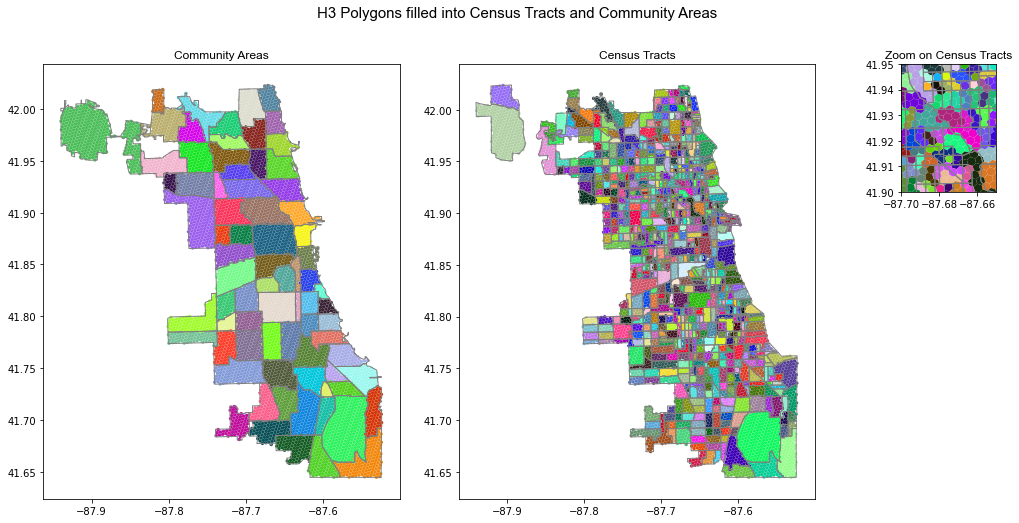

In [24]:
# Plotting results
fig,axes = create_gridplot( title = "H3 Polygons filled into Census Tracts and Community Areas",figsize=(18,8),gridsize=(3,5),plotsizes=[(3,2),(3,2),(1,1)],names=["Community Areas","Census Tracts","Zoom on Census Tracts"],tight_layout=True)

for com_area in h3_com_areas["com_area"].unique():
    color = list(np.random.choice(range(256), size=3)/256)
    gpd.GeoDataFrame(h3_com_areas[h3_com_areas["com_area"]==com_area],geometry="h3_geo_boundary").plot(ax=axes[0],color=color)

for census_tract in h3_census_tracts["census_tract"].unique():
    color = list(np.random.choice(range(256), size=3)/256)
    gpd.GeoDataFrame(h3_census_tracts[h3_census_tracts["census_tract"]==census_tract],geometry="h3_geo_boundary").plot(ax=axes[1],color=color)
    gpd.GeoDataFrame(h3_census_tracts[h3_census_tracts["census_tract"]==census_tract],geometry="h3_geo_boundary").plot(ax=axes[2],color=color)
    
chicago_com_areas.plot(color="none",edgecolor="grey",ax=axes[0])
chicago_census_tracts.plot(color="none",edgecolor="grey",ax=axes[1])
chicago_census_tracts.plot(color="none",edgecolor="grey",ax=axes[2])

axes[2].set_xlim(-87.7,-87.65)
axes[2].set_ylim(41.9,41.95)

plt.savefig("../data/figs/preparation/h3_cens_com")

In [68]:
chicago_com_areas

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry,centroid
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",POINT (-87.61868 41.83512)
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",POINT (-87.60322 41.82375)
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",POINT (-87.63242 41.80909)
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",POINT (-87.61786 41.81295)
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",POINT (-87.59618 41.80892)
...,...,...,...,...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,0,75584290.0209,0,74,74,0,0,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ...",POINT (-87.71319 41.69488)
73,MORGAN PARK,0,91877340.6988,0,75,75,0,0,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ...",POINT (-87.66905 41.68973)
74,OHARE,0,371835607.687,0,76,76,0,0,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",POINT (-87.89370 41.97568)
75,EDGEWATER,0,48449990.8397,0,77,77,0,0,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ...",POINT (-87.66342 41.98671)


In [69]:
print("Amount of Community Areas:",len(chicago_com_areas["area_num_1"].unique()))
print("Amount of Census Tracts:",len(chicago_census_tracts["geoid10"].unique()))

Amount of Community Areas: 77
Amount of Census Tracts: 801


With Census Tracts and Community Areas filled out with H3 Polygons, we can proceed by assigning each record to the most accurate approximation of Start and End H3 Polygon by selecting a random one from the set of most accurate information.

In [22]:
# Function to assign a random H3 to a ride of the set of H3 that lie within a census tract or community area
def get_approx_h3(census_tract,com_area):
    # if ride has census tract information
    if not math.isnan(census_tract):
        # get a dataset of all H3 within the particular census tract
        filtered_df = h3_census_tracts[h3_census_tracts["census_tract"]==census_tract]
        # If there are more than one H3 within the census tract
        if len(filtered_df.index)>1:
            # randomly pick one
            filtered_df_sample = filtered_df.sample(1)
            # and return string code and geometry of the H3
            return filtered_df_sample["h3_id"].iloc[0], filtered_df_sample["h3_geo_boundary"].iloc[0]
    
    # else, check if the community area is assigned and perform the same as above.
    if not math.isnan(com_area):
        filtered_df = h3_com_areas[h3_com_areas["com_area"]==com_area]
        if len(filtered_df.index)>1:
            filtered_df_sample = filtered_df.sample(1)
            return filtered_df_sample["h3_id"].iloc[0], filtered_df_sample["h3_geo_boundary"].iloc[0]
        
    return np.nan, np.nan

# Function that implements a for-loop to run the above function on the full data set and assign the information to the data.
def add_approx_h3(df,census_tract_colname,com_area_colname,new_ids_colname,new_polys_colname):
    # create empty vectors
    h3_ids=[]
    h3_polys=[]
    
    # run the for loop
    for _,row in df.iterrows():
        
        census_tract = row[census_tract_colname]
        com_area = row[com_area_colname]
        
        # pick random H3 and save information
        h3_id,h3_poly =get_approx_h3(census_tract,com_area)
        h3_ids.append(h3_id)
        h3_polys.append(h3_poly)
    
    # check whether new vector and full data set are of same length.
    if not len(h3_ids) == len(df.index) or not len(h3_polys)==len(df.index):
        print("something went wrong.")

    df[new_ids_colname]=h3_ids
    df[new_polys_colname]=h3_polys
    return df

# Run functions on data
df = add_approx_h3(df,"Pickup Census Tract","Pickup Community Area","PU_H3","PU_H3_poly")
df = add_approx_h3(df,"Dropoff Census Tract","Dropoff Community Area","DO_H3","DO_H3_poly")

To test if our algorithm worked correctly, we plot the trip amount per H3 hexagon of some random community areas and then across our whole dataset.

<AxesSubplot:>

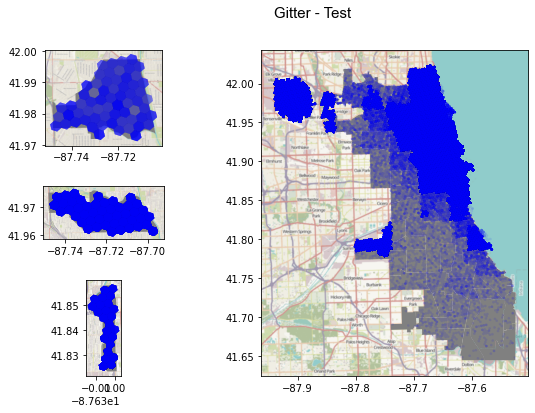

In [24]:
fig,axes=create_gridplot(title="Gitter - Test",figsize=(10,6),gridsize=(3,4),plotsizes=[(1,1),(3,3),(1,1),(1,1)],names=[])

# Plot one Test Community Area
test_comarea = 13.0
test_df = df[df["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[0],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_poly").plot(ax=axes[0],color="blue",alpha=0.1)
ctx.add_basemap(ax=axes[0],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[0],alpha=0)

# Plot all H3s
chicago_com_areas.plot(ax=axes[1],color="grey")
gpd.GeoDataFrame(df,geometry="PU_H3_poly").plot(ax=axes[1],color="blue",alpha=0.1)
ctx.add_basemap(ax=axes[1],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[1],alpha=0)

# Plot one Test Community Area
test_comarea = 14.0
test_df = df[df["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[2],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_poly").plot(ax=axes[2],color="blue",alpha=0.1)
ctx.add_basemap(ax=axes[2],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[2],alpha=0)

# Plot one Test Community Area
test_comarea = 34.0
test_df = df[df["Pickup Community Area"]==test_comarea]
chicago_com_areas[chicago_com_areas["area_num_1"]==test_comarea].plot(ax=axes[3],color="grey")
gpd.GeoDataFrame(test_df,geometry="PU_H3_poly").plot(ax=axes[3],color="blue",alpha=0.1)
ctx.add_basemap(ax=axes[3],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=axes[3],alpha=0)


The results look very convincing. From here on we have the great advantage to work with much granular geo spatial data. Eventhough, the granularity has been produced artifically, we are confident that our percedure to randomly distribute rides accross H3 is a close approximation of reality and gives our further analysis more power.

In [25]:
# getting the H3 Centroid
def get_centroid(poly):
    if isinstance(poly,shapely.geometry.polygon.Polygon):
        return poly.centroid
    return np.nan

df["PU_H3_Centroid"] = df.apply(lambda x: get_centroid(x["PU_H3_poly"]),axis=1)
df["DO_H3_Centroid"] = df.apply(lambda x: get_centroid(x["DO_H3_poly"]),axis=1)

In [26]:
# reassigning the Pick up/ Drop off long and lat coordinates of every ride to the H3 centroids
def get_long_lat(point,what="lat"):
    if isinstance(point,shapely.geometry.point.Point):
        if what == "lat":
            return point.y
        if what == "lng":
            return point.x
    return np.nan

df["Pickup Centroid Longitude"] = df.apply(lambda x: get_long_lat(x["PU_H3_Centroid"],what="lng"),axis=1)
df["Pickup Centroid Latitude"] = df.apply(lambda x: get_long_lat(x["PU_H3_Centroid"],what="lat"),axis=1)
df["Dropoff Centroid Longitude"] = df.apply(lambda x: get_long_lat(x["DO_H3_Centroid"],what="lng"),axis=1)
df["Dropoff Centroid Latitude"] = df.apply(lambda x: get_long_lat(x["DO_H3_Centroid"],what="lat"),axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089891 entries, 489487 to 2034369
Data columns (total 27 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     1089891 non-null  object        
 1   Taxi ID                     1089490 non-null  object        
 2   Trip Start Timestamp        1089891 non-null  datetime64[ns]
 3   Trip End Timestamp          1089891 non-null  datetime64[ns]
 4   Trip Seconds                1089891 non-null  float64       
 5   Trip Miles                  1089891 non-null  float64       
 6   Pickup Census Tract         761542 non-null   float64       
 7   Dropoff Census Tract        758473 non-null   float64       
 8   Pickup Community Area       1011796 non-null  float64       
 9   Dropoff Community Area      991307 non-null   float64       
 10  Fare                        1089891 non-null  float64       
 11  Tips               

------------------------------

# 3. Data Engineering

In [28]:
from haversine import haversine, Unit
df['PU_DISTANCE_CITY'] = df.apply(lambda row: 
                                  haversine((row["Pickup Centroid Latitude"], 
                                             row["Pickup Centroid Longitude"]), 
                                            (41.85003, -87.65005), Unit.MILES), 
                                  axis=1)
df['DO_DISTANCE_CITY'] = df.apply(lambda row: 
                                  haversine((row["Dropoff Centroid Latitude"], 
                                             row["Dropoff Centroid Longitude"]), 
                                            (41.85003, -87.65005), Unit.MILES), 
                                  axis=1)


df["DURATION_IN_MINUTES"] = df["Trip Seconds"]/60
df['DURATION_IN_MINUTES'] = df['DURATION_IN_MINUTES'].round(2)

df['MPH']=  df['Trip Miles']/df['Trip Seconds']*3600

In [29]:
def addDateCols(added_word, used_datetime,df_name): 

    #added word: Put your indivuword word to the string 
    #Month and weekday name
    df_name[added_word+'_MONTH_NAME'] = df_name[used_datetime].dt.month_name()
    df_name[added_word+'_WEEKDAY_NAME'] = df_name[used_datetime].dt.day_name()
    
    #Add week 
    df_name[added_word+"_WEEK"] = np.ceil(df_name[used_datetime].dt.dayofyear/7).astype(int)
    
    #Date
    df_name[added_word+"_DATE"] = df_name[used_datetime].dt.date

    #Month numeric
    df_name[added_word+'_MONTH'] = df_name[used_datetime].dt.month
    df_name[added_word+'_MONTH'] = pd.to_numeric(df_name[added_word+'_MONTH'])
    
    #Weekday numeric
    df_name[added_word+'_WEEKDAY'] = df_name[used_datetime].dt.dayofweek
    df_name[added_word+'_WEEKDAY'] = pd.to_numeric(df_name[added_word+'_WEEKDAY'])

    #Day numeric
    df_name[added_word+'_HOUR'] = df_name[used_datetime].dt.hour
    df_name[added_word+'_HOUR'] = pd.to_numeric(df_name[added_word+'_HOUR'])+1
    
    #isWorkday
    df_name[added_word+'_isWorkday'] = df[added_word+"_WEEKDAY"] < 5
    
    #Day of week
    #df_name[added_word+'_HOUR_OF_WEEK'] = (df_name[added_word+'_WEEKDAY']*24) + df_name[added_word+'_HOUR']
    
    return df_name

In [30]:
#Adding datetime columns
df = addDateCols("PU","Trip Start Timestamp",df)
df = addDateCols("DO","Trip Start Timestamp",df)

In [31]:
# Loading set of holiday dates for Chicago
# source: https://www.officeholidays.com/countries/usa/illinois/2017
illinois_holidays = pd.read_csv("../data/holidays_illinois.csv",sep=";")
illinois_holidays["date"] = pd.to_datetime(illinois_holidays["date"],format = '%d.%m.%Y').dt.date
illinois_holidays.sample(3)

,Holiday,date
12,Christmas,2017-12-24
7,Labor Day,2017-09-06
8,Columbus Day,2017-10-11


In [32]:
# Setting isWorkday to false for holidays
def adapt_workday(isWorkday,date):
    bol = isWorkday
    if date in illinois_holidays["date"].to_numpy():
        bol = False
    return bol

df["PU_isWorkday"] = df.apply(lambda x: adapt_workday(x["PU_isWorkday"],x["PU_DATE"]),axis=1)
df["DO_isWorkday"] = df.apply(lambda x: adapt_workday(x["DO_isWorkday"],x["DO_DATE"]),axis=1)

### Save cleaned Trip Data

In [33]:
#Write parquet of cleaned frame
df_compatible = df.drop(columns=["PU_H3_poly","DO_H3_poly","PU_H3_Centroid","DO_H3_Centroid"])
frame = pa.Table.from_pandas(df_compatible)
pq.write_table(frame, '../data/df_cleaned_{}.parquet'.format(date.today().strftime("%d_%m_%Y")))

_______________________________________

# 4. Weather Data

In [34]:
# Load and combine all weather data into one frame
# source: https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv
def read_weather_data(path,feature_name):
    fields = ['datetime', 'Chicago']
    weatherdf = pd.read_csv(path, skipinitialspace=True, usecols=fields)
    weatherdf = weatherdf.rename(columns={'Chicago': feature_name})
    weatherdf = weatherdf[(weatherdf["datetime"]>='2017-01-01')& (weatherdf["datetime"]<='2017-12-31')]
    weatherdf = weatherdf.reset_index()
    weatherdf = weatherdf.drop(['index'], axis=1)
    return weatherdf

temp_chi=read_weather_data('../data/temperature.csv',"Temperature")
hum_chi = read_weather_data('../data/humidity.csv',"Humidity")
wind_chi = read_weather_data('../data/wind_speed.csv',"Wind Speed")
des_chi =  read_weather_data('../data/weather_description.csv',"weather_description")

In [35]:
weather_hourly = temp_chi.merge(hum_chi, how='left', on='datetime')
weather_hourly = weather_hourly.merge(wind_chi, how='left', on='datetime')
weather_hourly = weather_hourly.merge(des_chi, how='left', on='datetime')
weather_hourly["datetime"] = pd.to_datetime(weather_hourly["datetime"])
weather_hourly["date"] = weather_hourly["datetime"].dt.date
weather_hourly["month"] = weather_hourly["datetime"].dt.month
print(weather_hourly["weather_description"].unique())
weather_hourly


['overcast clouds' 'scattered clouds' 'sky is clear' 'mist' 'haze'
 'broken clouds' 'light rain' 'moderate rain' 'drizzle'
 'light intensity drizzle' 'fog' 'few clouds' 'light snow' 'snow'
 'heavy snow' 'proximity thunderstorm'
 'proximity thunderstorm with drizzle' 'heavy intensity rain'
 'thunderstorm with rain' 'smoke' 'thunderstorm'
 'thunderstorm with light rain' 'proximity thunderstorm with rain'
 'thunderstorm with heavy rain' 'dust' 'proximity shower rain'
 'heavy intensity drizzle' 'thunderstorm with drizzle']


,datetime,Temperature,Humidity,Wind Speed,weather_description,date,month
0,2017-01-01 00:00:00,274.06,100.0,4.0,overcast clouds,2017-01-01,1
1,2017-01-01 01:00:00,272.94,50.0,4.0,scattered clouds,2017-01-01,1
2,2017-01-01 02:00:00,272.14,100.0,3.0,sky is clear,2017-01-01,1
3,2017-01-01 03:00:00,270.97,63.0,3.0,sky is clear,2017-01-01,1
4,2017-01-01 04:00:00,270.14,73.0,1.0,sky is clear,2017-01-01,1
...,...,...,...,...,...,...,...
7988,2017-11-29 20:00:00,281.34,52.0,2.0,few clouds,2017-11-29,11
7989,2017-11-29 21:00:00,281.69,65.0,4.0,sky is clear,2017-11-29,11
7990,2017-11-29 22:00:00,281.07,96.0,2.0,few clouds,2017-11-29,11
7991,2017-11-29 23:00:00,280.06,75.0,2.0,sky is clear,2017-11-29,11


In [36]:
# Adds a boolean value for whether the weather_description indicates precipitation
def is_prec(value):
    ret_value = 0
    if "drizzle" in value or "rain" in value or "snow" in value:
        ret_value = 1
    return ret_value

weather_hourly["has_precipitation"] = weather_hourly.apply(lambda x: is_prec(x["weather_description"]),axis=1)

In [37]:
# This aims to augment our data to include a measure of the intensity
# 0  if no precipitation, 
# 1 if declared "light",
# 2 if declared "moderate" or nothing
# 3 if declared "heavy"
    
def get_prec_intensity(value,has_prec):
    if not has_prec:
        return 0
    if "light" in value:
        return 1
    if "heavy" in value:
        return 3
    return 2
                                                                                                                                                                                                
weather_hourly["precipitation_intensity"] = weather_hourly.apply(lambda x: get_prec_intensity(x["weather_description"],x["has_precipitation"]),axis=1)

In [38]:
weather_hourly.head(3)

,datetime,Temperature,Humidity,Wind Speed,weather_description,date,month,has_precipitation,precipitation_intensity
0,2017-01-01 00:00:00,274.06,100.0,4.0,overcast clouds,2017-01-01,1,0,0
1,2017-01-01 01:00:00,272.94,50.0,4.0,scattered clouds,2017-01-01,1,0,0
2,2017-01-01 02:00:00,272.14,100.0,3.0,sky is clear,2017-01-01,1,0,0


### Save cleaned Weather Data

In [39]:
#Write parquet of cleaned frame
weather_frame = pa.Table.from_pandas(weather_hourly)
pq.write_table(weather_frame, '../data/weather_transformed_{}.parquet'.format(date.today().strftime("%d_%m_%Y")))